In [1]:
import os
import importlib
import re

import ase
from ase.visualize import view
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
import matplotlib.pyplot as plt

import ml_collections

from molnet import loss
from molnet.data import input_pipeline_online
from configs import root_dirs
from configs.tests import attention_test

2024-12-05 10:52:04.492129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
config = attention_test.get_config()
config.train_molecules = (0, 90000)
config.val_molecules = (90000, 100000)
config.rng_seed = 0
config.root_dir = root_dirs.get_root_dir()
config.num_workers = 8
config.batch_size = 1
config.interpolate_input_z = 15
config.z_cutoff = 1.0

In [6]:
tf.random.set_seed(config.rng_seed)
datasets = input_pipeline_online.get_datasets(config)

ds = iter(datasets['val'])
batch = next(ds)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 1479210051963560085
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 1988877809057057255
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing te

In [7]:
x = batch['images'][0]
y = batch['atom_map'][0]
xyz = batch['xyz'][0]
sw = batch['sw'][0]

print(xyz[:, -1])
print(x.shape, y.shape, xyz.shape)
print(f"ymin, ymax: {y.min()}, {y.max()}")
print(sw)
print(xyz)

[8. 8. 8. 8. 8. 8. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
(128, 128, 15, 1) (128, 128, 15, 5) (54, 5)
ymin, ymax: 0.0, 0.9875322580337524
[[ 0.         0.         0.       ]
 [15.9       15.9        1.9000001]]
[[ 9.84777069e+00  9.89732838e+00  4.20705192e-02 -2.91770011e-01
   8.00000000e+00]
 [ 6.05194569e+00  6.00283766e+00 -1.60307623e-02 -2.91669995e-01
   8.00000000e+00]
 [ 1.16950884e+01  8.15397930e+00  5.08097336e-02 -2.55039990e-01
   8.00000000e+00]
 [ 4.20483685e+00  7.74608755e+00 -4.96504642e-02 -2.54949987e-01
   8.00000000e+00]
 [ 1.24129562e+01  5.58295441e+00  3.92651409e-02 -1.87319994e-01
   8.00000000e+00]
 [ 3.48746300e+00  1.03168917e+01 -6.75550550e-02 -1.87250003e-01
   8.00000000e+00]
 [ 5.76953793e+00  1.10192137e+01 -2.96130497e-02  2.61499994e-02
   6.00000000e+00]
 [ 1.01306486e+01  4.88068533e+00  1.61891468e-02  2.60600001e-02
   6.00000000e+00]
 

0.98753226 0.0


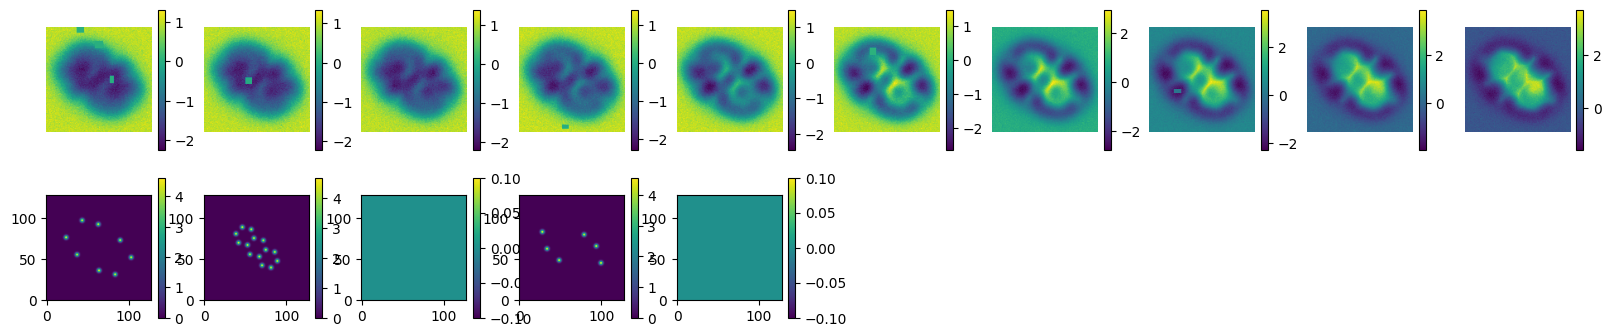

In [8]:
fig = plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    im = plt.imshow(x[..., i, 0], origin='lower')
    plt.colorbar(im)
    ax.axis('off')

ymax, ymin = y.max(), y.min()
for i in range(5):
    ax = plt.subplot(2, 10, 10 + i + 1)
    im = plt.imshow(y[..., i].sum(axis=-1), origin='lower')
    plt.colorbar(im)

print(ymax, ymin)

Total mean = 1.05e-03, std = 9.92e-01


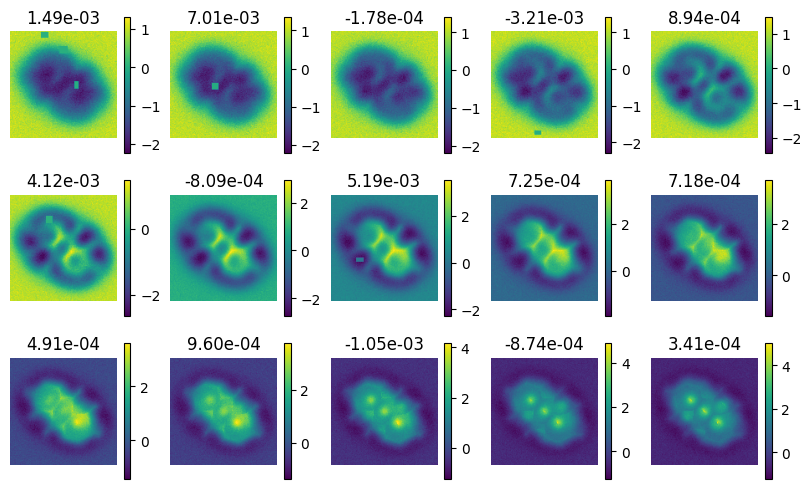

In [9]:
ncols = 5
nrows = x.shape[-2] // ncols
fig = plt.figure(figsize=(ncols * 2, nrows * 2))

for i in range(x.shape[-2]):
    ax = plt.subplot(nrows, ncols, i + 1)
    im = ax.imshow(x[..., i, 0], origin='lower')
    x_mean = x[..., i, 0].mean()
    x_std = x[..., i, 0].std()
    plt.title(f"{x_mean:.2e}")
    plt.axis('off')
    plt.colorbar(im)

print(f"Total mean = {x.mean():.2e}, std = {x.std():.2e}")

ymin, ymax: 0.0, 0.9875322580337524


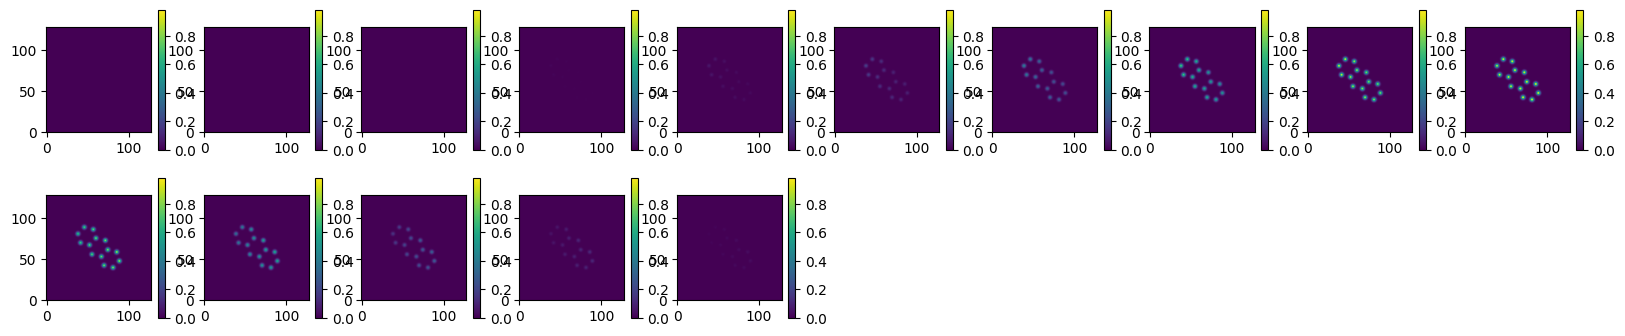

In [10]:
# Plot entire stack of y[..., -1]
channel = 1
ymin, ymax = y.min(), y.max()
print(f"ymin, ymax: {ymin}, {ymax}")

fig = plt.figure(figsize=(20, 4))
for i in range(y.shape[-2]):
    ax = plt.subplot(2, 10, i + 1)
    im = plt.imshow(y[..., i, channel], origin='lower', vmin=ymin, vmax=ymax)
    plt.colorbar(im)


In [62]:
mol = ase.Atoms(positions=xyz[:, :3], numbers=xyz[:, -1].astype(int))
print(mol.positions, mol.numbers)
view(mol)

[[ 6.00285959e+00  9.84782600e+00  4.20705192e-02]
 [ 9.89735031e+00  6.05200148e+00 -1.60307623e-02]
 [ 7.74620867e+00  1.16951447e+01  5.08097336e-02]
 [ 8.15410042e+00  4.20489264e+00 -4.96504642e-02]
 [ 1.03172340e+01  1.24130116e+01  3.92651409e-02]
 [ 5.58329630e+00  3.48751879e+00 -6.75550550e-02]
 [ 4.88097429e+00  5.76959372e+00 -2.96130497e-02]
 [ 1.10195026e+01  1.01307049e+01  1.61891468e-02]
 [ 5.88418722e+00  4.80316830e+00 -4.47154604e-02]
 [ 1.00162868e+01  1.10971298e+01  3.00037656e-02]
 [ 5.21381521e+00  7.12904835e+00 -5.17002307e-03]
 [ 1.06865711e+01  8.77100945e+00  6.73847599e-03]
 [ 7.24797297e+00  5.19886923e+00 -3.44707519e-02]
 [ 9.01093292e+00  6.93245840e+00 -5.78428851e-03]
 [ 6.88933992e+00  8.96735954e+00  2.43047290e-02]
 [ 6.54947519e+00  7.53597641e+00  2.42732535e-03]
 [ 9.35084152e+00  8.36395454e+00  8.58352520e-03]
 [ 7.58603239e+00  6.56057882e+00 -1.19092409e-02]
 [ 8.31428337e+00  9.33932877e+00  2.34991871e-02]
 [ 8.65235710e+00  1.07012062e+

<Popen: returncode: None args: ['/u/79/kurkil1/unix/.venvs/tf-2.13/bin/pytho...>

usage: ase [-h] [--version] [-T]
           {help,info,test,gui,db,run,band-structure,build,dimensionality,eos,ulm,find,nebplot,nomad-upload,nomad-get,convert,reciprocal,completion,diff,exec}
           ...
ase: error: TclError: no display name and no $DISPLAY environment variable
To get a full traceback, use: ase -T gui ...


## Create "fake" webdataset for testing

In [ ]:
import webdataset as wds

In [ ]:
def generator(N=100):
    for i in range(N):
        sample = {
            "__key__": str(i*100),
            "label.cls": i*100,
        }
        yield sample

In [ ]:
temp_outputdir = "./temp/shard_1.tar"

os.makedirs(os.path.dirname(temp_outputdir), exist_ok=True)

gen = generator(100)
with wds.TarWriter(temp_outputdir) as sink:
    for sample in gen:
        sink.write(sample)

In [ ]:
shardlist = [
    os.path.join("./temp", shard) for shard in os.listdir("./temp")
]
ds = wds.DataPipeline(
    wds.SimpleShardList(shardlist),

    wds.shuffle(100),

    wds.tarfile_to_samples(),

    wds.shuffle(1000),

    wds.decode("l"),

    wds.to_tuple("__key__", "label.cls"),

    wds.batched(16)
)

In [ ]:
loader = iter(ds)
end_after_this_iteration = False

for i in range(1000):
    try:
        batch = next(loader)
    except StopIteration:
        if end_after_this_iteration:
            break
        print()

        loader = iter(ds)
        end_after_this_iteration = True
        continue

    print(batch[0])

['8900', '2100', '2000', '7300', '1', '6000', '6700', '400', '2800', '3', '1000', '12', '10', '7600', '2500', '27']
['3000', '6600', '22', '2300', '23', '31', '5600', '15', '24', '7700', '9100', '9', '7000', '18', '7800', '9500']
['1900', '46', '66', '3300', '62', '11', '72', '71', '36', '6800', '57', '33', '4600', '7', '4400', '8100']
['9800', '14', '8800', '5700', '1800', '3700', '47', '2600', '600', '6100', '2700', '21', '97', '43', '68', '7200']
['5800', '800', '3900', '8400', '80', '1600', '83', '51', '37', '7400', '6900', '1700', '4900', '87', '1300', '63']
['4300', '30', '9200', '2', '94', '9000', '8700', '95', '52', '7100', '2900', '38', '4', '300', '3600', '73']
['1200', '45', '6200', '100', '39', '49', '13', '4200', '65', '2200', '4500', '85', '5', '7900', '40', '8200']
['86', '9600', '61', '55', '4700', '89', '8600', '19', '76', '77', '3100', '75', '17', '48', '4000', '9900']
['6500', '5200', '8500', '4800', '29', '5900', '69', '34', '3200', '32', '58', '70', '7500', '0', '3

## test tf atom map computation

In [31]:
def compute_map(xyz, sigma=0.2):
    x = tf.linspace(tf.constant(0, dtype=tf.float32), 16, 128)
    y = tf.linspace(tf.constant(0, dtype=tf.float32), 16, 128)
    z = tf.range(14, 16, 0.1, dtype=tf.float32)

    X, Y, Z = tf.meshgrid(x, y, z, indexing='xy')

    # Compute atom maps.
    maps_h = tf.zeros_like(X)
    maps_c = tf.zeros_like(X)
    maps_n = tf.zeros_like(X)
    maps_o = tf.zeros_like(X)
    maps_f = tf.zeros_like(X)

    for atom in xyz:
        if atom[-1] == 1:
            maps_h += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )
        elif atom[-1] == 6:
            maps_c += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )
        elif atom[-1] == 7:
            maps_n += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )
        elif atom[-1] == 8:
            maps_o += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )
        elif atom[-1] == 9:
            maps_f += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )

    atom_map = tf.stack([maps_h, maps_c, maps_n, maps_o, maps_f], axis=0)
    atom_map = tf.transpose(atom_map, perm=[1, 2, 3, 0])
    return atom_map


In [32]:
xyz = tf.random.uniform((xyz.shape[0], 3), 0, 16)
species = tf.random.uniform(xyz.shape, 6, 10, dtype=tf.int32)
species = tf.cast(species, tf.float32)[:,0][..., None]
xyz = tf.concat([xyz, species], axis=-1)

m = compute_map(xyz)

(128, 128, 20, 5)


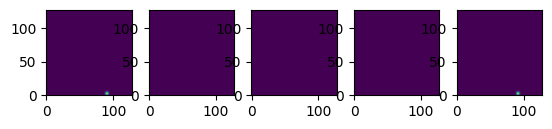

In [36]:
print(m.shape)

for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(m[..., -i, -1], origin='lower')

## data augmentation

In [2]:
def plot_stack(x):
    xmax = tf.reduce_max(x).numpy()
    fig, ax = plt.subplots(1, 5)
    for i in range(5):
        ax[i].imshow(x[..., i, 0], vmin=0, vmax=xmax)

In [6]:
x = np.arange(128)
y = np.arange(128)

x, y = np.meshgrid(x, y)
z = x + y
z = z[..., None]
z = np.tile(z, (1, 1, 5))

z2 = x * y
z2 = z2[None, ..., None]
z2 = np.tile(z2, (5, 1, 1, 20))

orig_batch = {
    "images": z,
    "atom_map": z2,
    "xyz": np.zeros((5, 20, 3)),
}

print(orig_batch['images'].shape)
print(orig_batch['atom_map'].shape)

(128, 128, 5)
(5, 128, 128, 20)


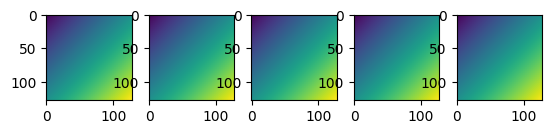

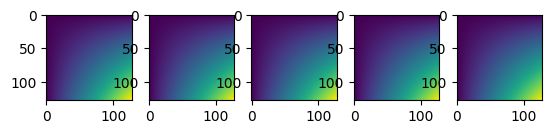

In [7]:
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(z[..., i])

fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(z2[i, ..., 0])

In [16]:
print(orig_batch['images'].shape)

batch = input_pipeline._preprocess_images(
    orig_batch,
    noise_std=0.1,
    interpolate_z=16,
    cutout_probs=[0.5, 0.3, 0.1, 0.05, 0.5],
)

print(orig_batch['images'].shape)

print(batch['images'].shape)
print(batch['atom_map'].shape)

(128, 128, 5)
(128, 128, 5)
(128, 128, 16, 1)
(128, 128, 16, 5)


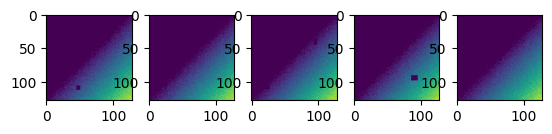

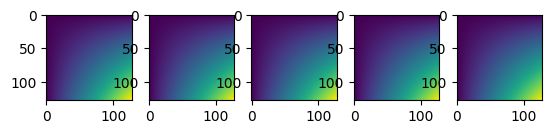

In [17]:
plot_stack(batch['images'])
plot_stack(batch['atom_map'])